In [ ]:
"""
File Created: 2023-04-19
Author: Patrick G. Cho
Contact: pcho@nd.edu
Purpose: IWC Metric Heat Map and Correlations to Precipitation Isotopes for Positive and Negative IWC Years from 1979 to 2019

Details:
This script is for determining the relationship between the different IWC metrics and Precipitation Isotopes in the Indian Ocean Basin.
It uses some functions that I created to calculate amount-weighted annual means that is available in my GitHub Repository. 
"""

# Load Data and Packages

In [1]:
# Data Management
import pandas as pd
import xarray as xr
import cftime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

# Correlation Analysis
import numpy as np
import numpy.ma as ma
from scipy import stats
from scipy.stats import pearsonr

# Weighted Means
from amount_weighted_ann_mean import amount_weighted_ann_mean
from weighted_temporal_mean import weighted_temporal_mean

# Image Resolution on MacOS
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
# Read IWC Metrics
metrics = pd.read_csv('YOUR_FILE_PATH')
metrics['time'] = pd.to_datetime(metrics['time'])
metrics = metrics.set_index('time')['1957-12-16':'2013-12-16']

# Extract Monthly Metrics
metricsMon = metrics[['u10', 'DMI', 'dSLP', 'dSLPP', 'SOI', 'NINO']].copy()
metricsMon['Year'] = metricsMon.index.year.values

# Resample Metrics to Annual Resolution
metrics = metrics[['u10', 'DMI', 'dSLP', 'dSLPP']].resample('Y').mean()
metrics['Year'] = metrics.index.year.values

# Read Winds data (ERA5)
era = xr.open_dataset('YOUR_FILE_PATH')
era = era.coarsen(longitude=10).mean().coarsen(latitude=7).mean()
era = era.assign_coords(longitude=(((era.longitude + 180) % 360) - 180)).sortby(variables='longitude', ascending=True)
era = era.sortby(variables='latitude', ascending=True).rename({'latitude': 'Latitude', 'longitude': 'Longitude'})
era = era.sel(Latitude=slice(-40, 30), Longitude=slice(25, 120), time=slice('1957', '2013'))

# Read Sea Level Pressure data (HadSLP)
hadslp = xr.open_dataset('YOUR_FILE_PATH')
hadslp = hadslp.assign_coords(lon=(((hadslp.lon + 180) % 360) - 180))
hadslp = hadslp.sortby(variables=['lon', 'lat'], ascending=True).rename({'lat': 'Latitude', 'lon': 'Longitude'})
hadslp = hadslp.sel(Latitude=slice(-40, 30), Longitude=slice(25, 120), time=slice('1957', '2013'))

# Read ECHAM data (1958-2013)
a = xr.open_dataset('YOUR_FILE_PATH')
a = a.rename({'lat': 'Latitude', 'lon': 'Longitude'})
a = a.assign_coords(Longitude=((a.Longitude + 180) % 360) - 180).sortby(variables=['Longitude', 'Latitude'], ascending=True)
a = a.mean(dim='lev')

b = xr.open_dataset('YOUR_FILE_PATH')
b = b.rename({'lat': 'Latitude', 'lon': 'Longitude'})
b = b.assign_coords(Longitude=((b.Longitude + 180) % 360) - 180).sortby(variables=['Longitude', 'Latitude'], ascending=True)

echam = a.merge(b).rename({'wisoaprt_d': 'd18O_P', 'aprt': 'precip'})

# Set Bounding box for Indo-Pacific Oceanic Basin (IOB)
IOB = echam.sel(Latitude=slice(-40, 30), Longitude=slice(25, 120))

# Heatmap and Timeseries

## Figure S1; Heatmap

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Text(0.5, 1.0, 'IWC Metric Heatmap; Monthly')

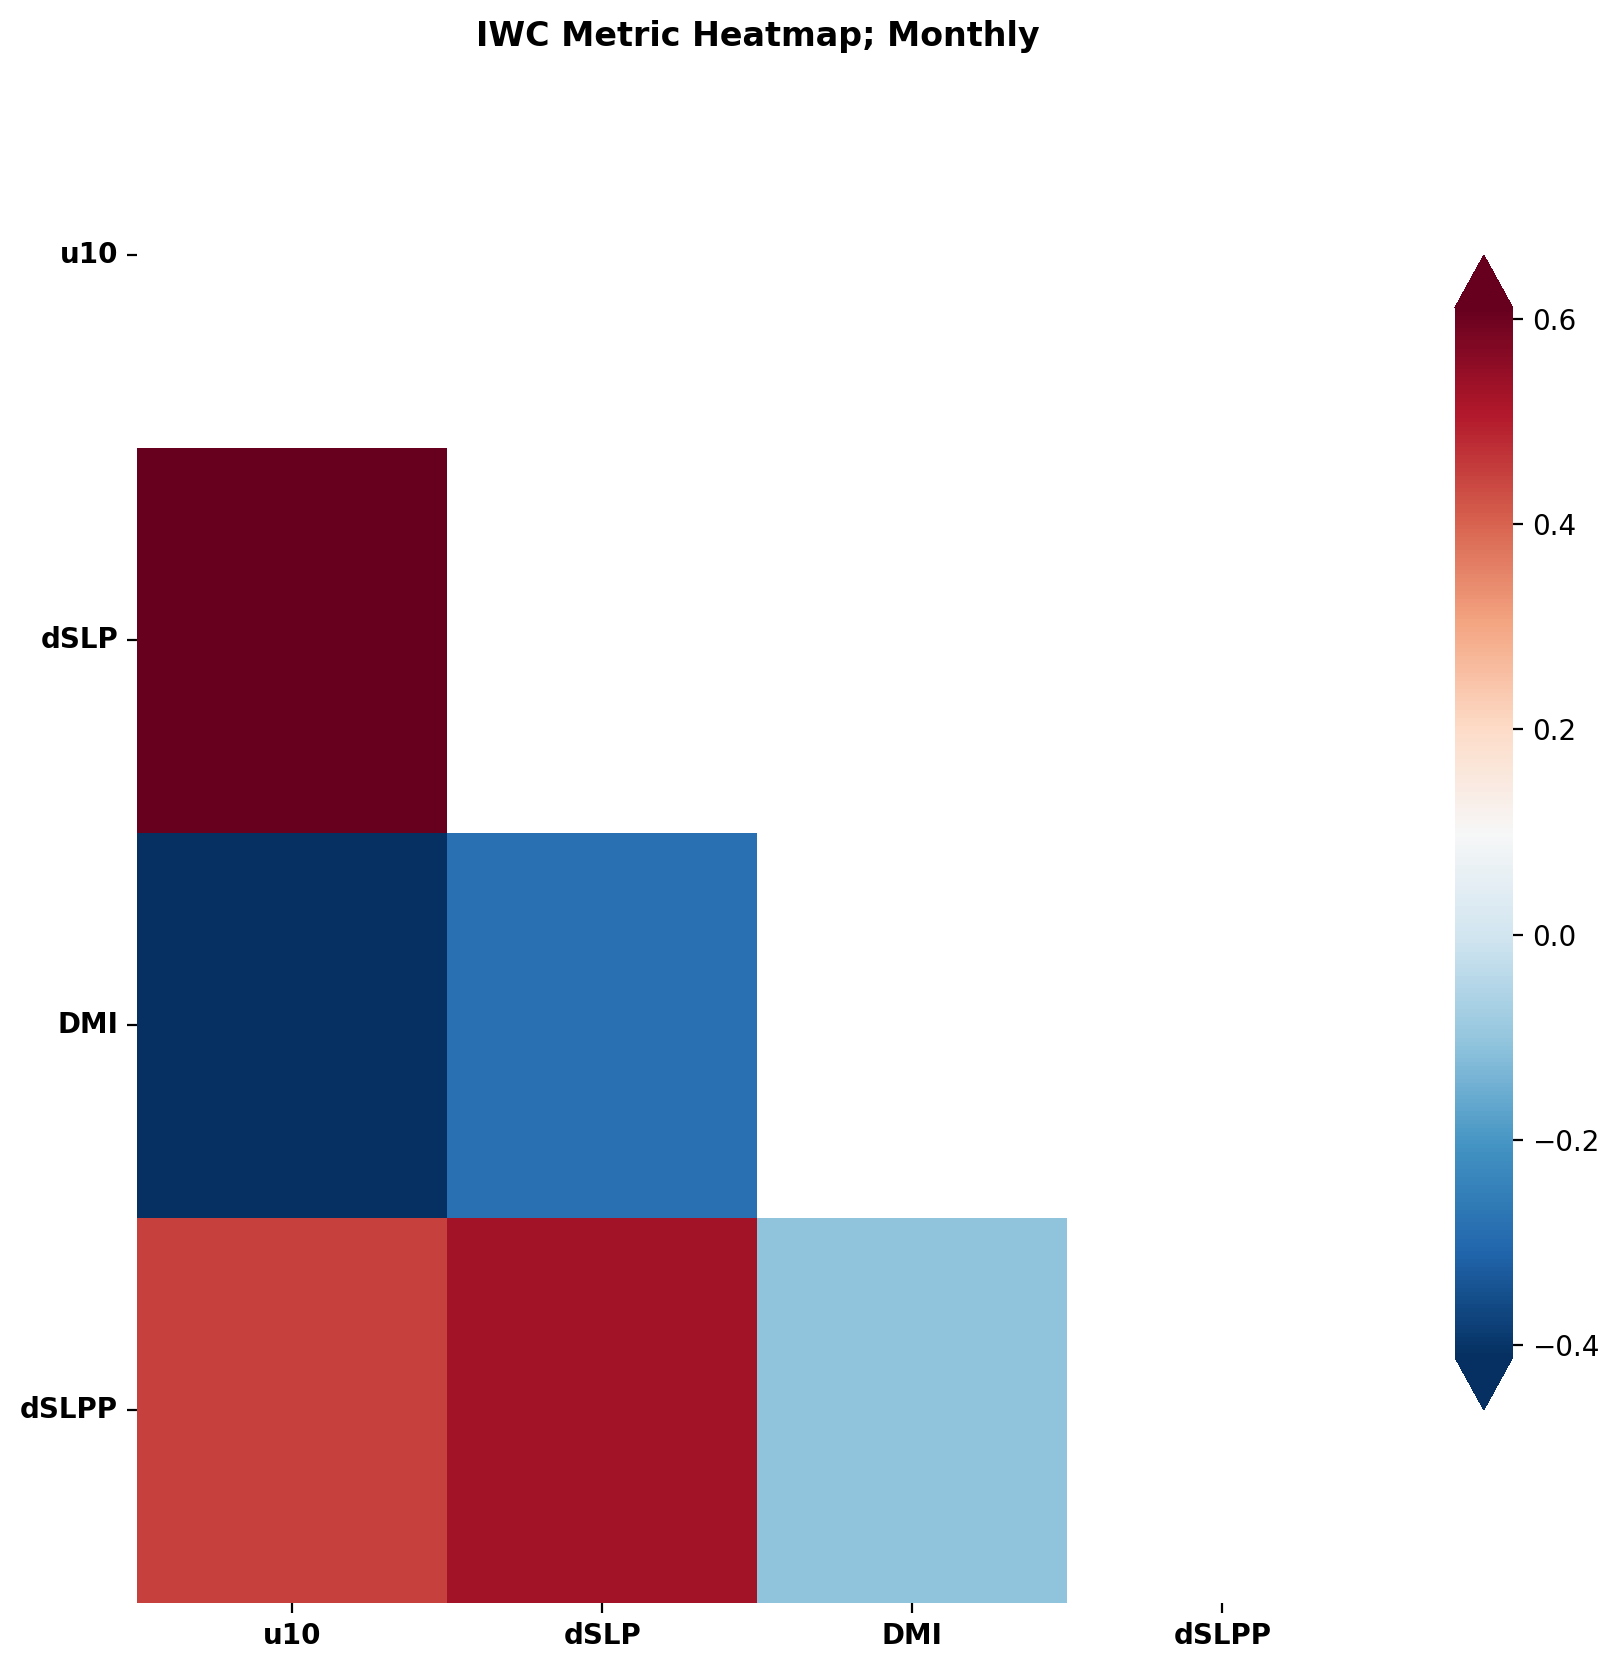

In [19]:
c = metricsMon[['u10','dSLP','DMI','dSLPP']].corr()
mask = np.triu(np.ones_like(c, dtype=bool))

plt.figure(figsize = (10, 10))
sns.heatmap(c, mask = mask, cmap = 'RdBu_r', annot = True, cbar_kws = {'shrink': 0.75, 'extend':'both'})
plt.xticks(fontweight = 'bold')
plt.yticks(rotation = 0, fontweight = 'bold')
plt.title('IWC Metric Heatmap; Monthly', fontweight = 'bold')

## Figure S1; Timeseries

In [27]:
# Function to calculate annual mean and anomaly
def calculate_annual_metrics(data, variable):
    annual_mean = data[variable].resample(time='1Y').mean()
    anomaly = annual_mean - annual_mean.mean(dim='time')
    return annual_mean, anomaly

# Function to select years for positive and negative phases
def select_years(data, metric, condition):
    years = data.loc[data[metric] * condition > 0, 'Year'].values
    return data.loc[data['Year'].isin(years)]

# Function to calculate wind speed and direction
def calculate_wind_metrics(data, lat_slice):
    uwind = data.u10.sel(Latitude=slice(lat_slice)).resample(time='1Y').mean()
    vwind = data.v10.sel(Latitude=slice(lat_slice)).resample(time='1Y').mean()
    
    wind_speed = np.sqrt(uwind**2 + vwind**2)
    wind_direction = np.arctan2(vwind, uwind) * 180/np.pi
    
    return uwind, vwind, wind_speed, wind_direction

# Function to calculate SLP difference
def calculate_slp_difference(data, pos_years, neg_years):
    press = data.slp.resample(time='1Y').mean()
    press_pos = press.sel(time=press.time.dt.year.isin(pos_years)).mean(dim='time')
    press_neg = press.sel(time=press.time.dt.year.isin(neg_years)).mean(dim='time')
    return press_pos - press_neg

In [28]:
# Calculate isotopes and precipitation metrics
isotopes, isotopes_anomaly = calculate_annual_metrics(IOB, 'd18O_P')
precip_mean, precip_anomaly = calculate_annual_metrics(IOB, 'precip')
precip_anomaly -= precip_anomaly.mean(dim='time')

# Select years for positive and negative phases
upos = select_years(metrics, 'u10', -1)
uneg = select_years(metrics, 'u10', 1)
Ppos = select_years(metrics, 'dSLP', -1)
Pneg = select_years(metrics, 'dSLP', 1)

# Select years for isotopes and metrics
isoUpos = isotopes.sel(time=isotopes.time.dt.year.isin(upos.Year))
isoUneg = isotopes.sel(time=isotopes.time.dt.year.isin(uneg.Year))
isoPpos = isotopes.sel(time=isotopes.time.dt.year.isin(Ppos.Year))
isoPneg = isotopes.sel(time=isotopes.time.dt.year.isin(Pneg.Year))

metricsUpos = metrics.loc[metrics.Year.isin(upos.Year)]
metricsUneg = metrics.loc[metrics.Year.isin(uneg.Year)]
metricsPpos = metrics.loc[metrics.Year.isin(Ppos.Year)]
metricsPneg = metrics.loc[metrics.Year.isin(Pneg.Year)]

# Calculate wind metrics
uwindPos, vwindPos, poswindspd, poswind_direction = calculate_wind_metrics(era, '-10,10')
uwindNeg, vwindNeg, negwindspd, negwind_direction = calculate_wind_metrics(era, '-10,10')

# Calculate SLP difference
press_diff = calculate_slp_difference(hadslp, Ppos.Year, Pneg.Year)

# Calculate isotope averages
posIso = isotopes.sel(time=isotopes.time.dt.year.isin(upos.Year)).mean(dim='time')
negIso = isotopes.sel(time=isotopes.time.dt.year.isin(uneg.Year)).mean(dim='time')

diffI = abs(posIso) - abs(negIso)

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


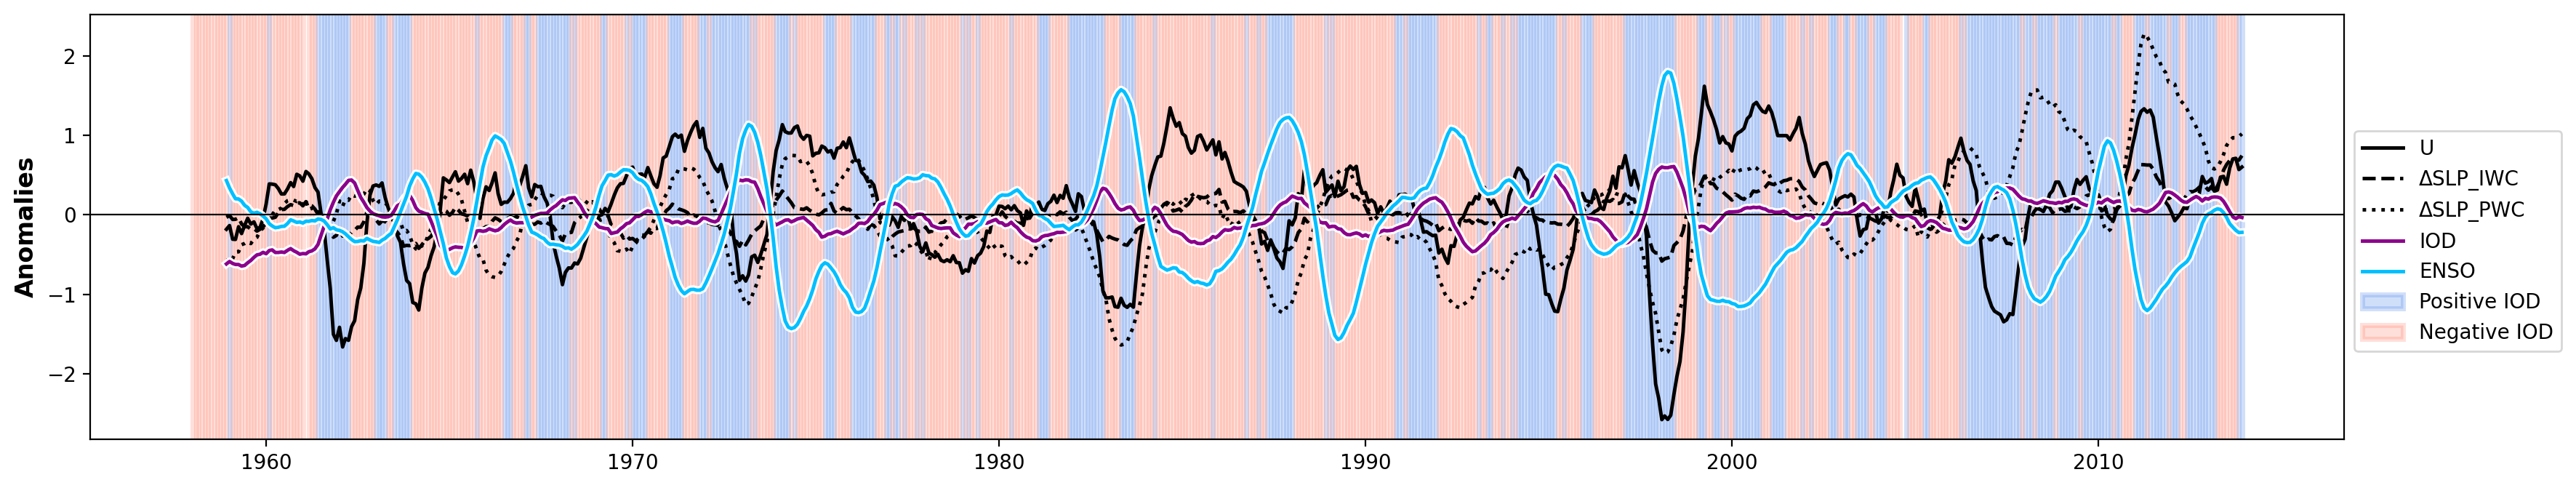

In [29]:
# TS of Metrics
fig = plt.figure(figsize=(20,18), layout = 'tight')
gs = gridspec.GridSpec(nrows=4, ncols=2, hspace = 0.25, figure = fig)

# IWC Metrics Time Series
pos = metricsMon.loc[metricsMon['DMI'] > 0, 'Year']
neg = metricsMon.loc[metricsMon['DMI'] < 0, 'Year']

ax0 = fig.add_subplot(gs[0,:])
ax0.plot(metricsMon.u10.rolling(12).mean(), color='black', label = 'U', linewidth = 1.75, linestyle = 'solid')
ax0.plot(metricsMon.dSLP.rolling(12).mean(), color='black', label = 'ΔSLP_IWC', linewidth = 1.75, linestyle = 'dashed')
ax0.plot(metricsMon.dSLPP.rolling(12).mean(), color='black', label = 'ΔSLP_PWC', linewidth = 1.75, linestyle = 'dotted')
ax0.plot(metricsMon.DMI.rolling(12).mean(), color = 'white', label = 'IOD', linewidth = 4, linestyle = 'solid')
ax0.plot(metricsMon.DMI.rolling(12).mean(), color = 'darkmagenta', label = 'IOD', linewidth = 1.75, linestyle = 'solid')
ax0.plot(metricsMon.NINO.rolling(12).mean(), color = 'white', label = 'ENSO', linewidth = 4, linestyle = 'solid')
ax0.plot(metricsMon.NINO.rolling(12).mean(), color = 'deepskyblue', label = 'ENSO', linewidth = 1.75, linestyle = 'solid')
ax0.axhline(y = 0, color = 'black', linestyle = 'solid', linewidth = 0.8)

for i in range(len(pos)):
    ax0.axvspan(pos.index[i],pos.index[i], color = 'cornflowerblue', alpha = 0.3, linewidth = 2.5, label = 'Positive IOD')
for j in range(len(neg)):
    ax0.axvspan(neg.index[j],neg.index[j], color = 'tomato', alpha = 0.2, linewidth = 2.5, label = 'Negative IOD')

ax0.set_ylabel('Anomalies', fontsize = 12, fontweight = 'bold')
handles, labels = ax0.get_legend_handles_labels()
dict_of_labels = dict(zip(labels, handles))
ax0.legend(dict_of_labels.values(), dict_of_labels.keys(),bbox_to_anchor=(1, 0.75))